In [1]:
import os
import sys
sys.path.append("../")
from concerto_function5_3 import *
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
#Select an available GPU to run on a multi-GPU computer or you can run it directly on the CPU without executing this cell
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '3' 
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 

In [4]:
path = './data/hp_rmSchwann_commonCelltype.loom'
adata = sc.read(path)

# preprocess

In [5]:
adata = preprocessing_rna(adata,n_top_features=2000,is_hvg=True,batch_key='tech')

... storing 'celltype' as categorical
... storing 'dataset' as categorical
... storing 'orig.ident' as categorical
... storing 'replicate' as categorical
... storing 'tech' as categorical


Processed dataset shape: (14865, 2000)


/home/CXxie/.conda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
adata_ref = adata[adata.obs['tech'] != 'indrop']
adata_query = adata[adata.obs['tech'] == 'indrop']
save_path = './'
if not os.path.exists(save_path):
    os.makedirs(save_path)
adata_ref.write_h5ad(save_path + 'adata_ref.h5ad')
adata_query.write_h5ad(save_path + 'adata_query.h5ad')

# make TF-record
TF-record is a binary file containing sequences of serialized byte-strings for the sharding file in TensorFlow, which is especially suitable for streaming data input network.

In [7]:
ref_tf_path = concerto_make_tfrecord(adata_ref,tf_path = save_path + 'tfrecord/ref_tf/',batch_col_name = 'tech')
query_tf_path = concerto_make_tfrecord(adata_query,tf_path = save_path + 'tfrecord/query_tf/',batch_col_name = 'tech')

View of AnnData object with n_obs × n_vars = 6309 × 2000
    obs: 'celltype', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'replicate', 'tech', 'n_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
counter: 1000 shape: (2000,), batch: 0
counter: 2000 shape: (2000,), batch: 1
counter: 3000 shape: (2000,), batch: 1
counter: 4000 shape: (2000,), batch: 2
counter: 5000 shape: (2000,), batch: 2
counter: 6000 shape: (2000,), batch: 3
View of AnnData object with n_obs × n_vars = 8556 × 2000
    obs: 'celltype', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'replicate', 'tech', 'n_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
counter: 1000 shape: (2000,), batch: 0
counter: 2000 shape: (2000,), batch: 0
counter: 3000 shape: (2000,), batch: 0
counter: 40

# train

In [8]:

weight_path = save_path + 'weight/'
concerto_train_ref_query(ref_tf_path,query_tf_path,weight_path,super_parameters={'batch_size': 64, 'epoch_pretrain': 3,'epoch_fineturn': 1, 'lr': 1e-4,'drop_rate': 0.1})

./tfrecord/ref_tf/tf_2.tfrecord
Epoch 1, step 5, simclr loss: 8.4342.
Epoch 1, step 10, simclr loss: 7.7868.
Epoch 1, step 15, simclr loss: 7.0632.
Epoch 1, step 20, simclr loss: 6.3000.
Epoch 1, step 25, simclr loss: 5.4929.
Epoch 1, step 30, simclr loss: 4.6517.
Epoch 1, step 35, simclr loss: 3.7238.
./tfrecord/ref_tf/tf_0.tfrecord
Epoch 1, step 5, simclr loss: -4.3534.
Epoch 1, step 10, simclr loss: -5.5761.
./tfrecord/ref_tf/tf_3.tfrecord
Epoch 1, step 5, simclr loss: -10.9616.
./tfrecord/ref_tf/tf_1.tfrecord
Epoch 1, step 5, simclr loss: -17.4294.
Epoch 1, step 10, simclr loss: -19.3898.
Epoch 1, step 15, simclr loss: -21.4483.
Epoch 1, step 20, simclr loss: -23.0273.
Epoch 1, step 25, simclr loss: -24.0105.
Epoch 1, step 30, simclr loss: -25.1258.
./tfrecord/ref_tf/tf_3.tfrecord
Epoch 2, step 5, simclr loss: -29.4043.
./tfrecord/ref_tf/tf_1.tfrecord
Epoch 2, step 5, simclr loss: -30.6263.
Epoch 2, step 10, simclr loss: -31.5402.
Epoch 2, step 15, simclr loss: -31.9354.
Epoch 2, s

'./weight/'

# test

In [9]:
weight_path = save_path + 'weight/'
ref_tf_path = save_path + 'tfrecord/ref_tf/'
query_tf_path = save_path + 'tfrecord/query_tf/'
ref_embedding,query_embedding,ref_id,query_id = concerto_test_ref_query(weight_path,ref_tf_path,query_tf_path,super_parameters=None)

./tfrecord/ref_tf/tf_2.tfrecord
./tfrecord/ref_tf/tf_0.tfrecord
./tfrecord/ref_tf/tf_1.tfrecord
./tfrecord/ref_tf/tf_3.tfrecord
./tfrecord/query_tf/tf_0.tfrecord
query embedding shape (8544, 128)
reference embedding shape (6240, 128)
ref id length 6240
query id length 8544


# NN-voting classifier

In [10]:
adata_ref = sc.read(save_path + 'adata_ref.h5ad')
query_neighbor,query_prob = knn_classifier(ref_embedding,query_embedding,adata_ref,ref_id,column_name='celltype',k=5)

8544 85


# Calculate ACC, F1-score

In [11]:
adata_query = sc.read(save_path + 'adata_query.h5ad')
adata_query_1 = adata_query[query_id]
acc = accuracy_score(adata_query_1.obs['celltype'],query_neighbor)
f1 = f1_score(adata_query_1.obs['celltype'], query_neighbor, average=None)
f1_median = np.median(f1)
print('acc:{:.2f} f1-score:{:.2f}'.format(acc,f1_median))

acc:0.97 f1-score:0.95


# Plot cell embeddings

In [12]:
adata_ref_1 = adata_ref[ref_id]
adata_ref_1.obsm['X_embedding'] = ref_embedding
adata_query_1.obsm['X_embedding'] = query_embedding
adata_all = adata_ref_1.concatenate(adata_query_1)

In [13]:
batch_list = []
for i in adata_all.obs['batch'].tolist():
    if i == '0':
        batch_list.append('reference')
    else:
        batch_list.append('query')  
adata_all.obs['batch'] = batch_list

... storing 'dataset' as categorical
... storing 'orig.ident' as categorical
... storing 'replicate' as categorical
... storing 'tech' as categorical
... storing 'batch' as categorical


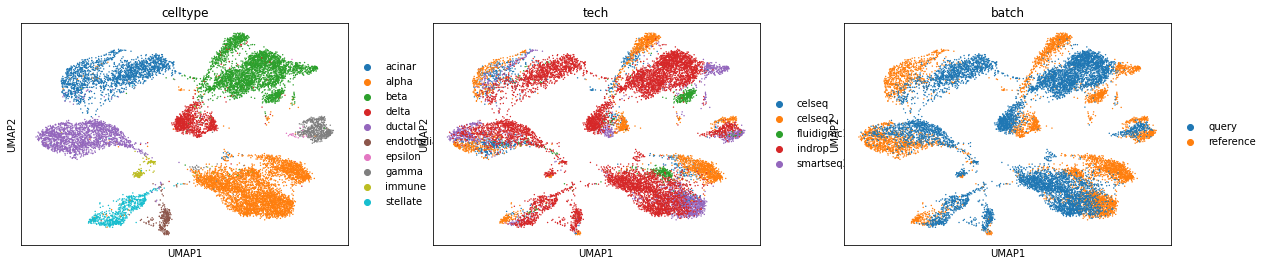

In [14]:
sc.pp.neighbors(adata_all, use_rep='X_embedding')
sc.tl.umap(adata_all)
sc.tl.leiden(adata_all)
sc.pl.umap(adata_all, color=['celltype','tech','batch'])